In [1]:
from keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from mlts.preprocessor.stock import *
import pandas as pd
import os
import glob
import pickle as pkl
import xgboost
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def data_loader(model_name, dataset_name):
    
    dataset = pd.read_csv(f'mlts/static/datasets/original/{dataset_name}.csv',parse_dates=['Date'])
    dataset_copy = dataset.copy()
    preprocessor = StockPreprocessor()
    preprocessed_data = preprocessor.preprocess(dataset_copy)
#     display(preprocessed_data.head())
    
    dataset = dataset.set_index('Date')
    dataset = dataset.loc[preprocessed_data.index]
    
    data_train, data_test = split_data(dataset)
    preprocessed_data_train, preprocessed_data_test = split_data(preprocessed_data)
    
    target_var = "adj_close"
    input_vars = preprocessed_data_test.columns.drop(target_var)
    X = np.array(preprocessed_data_test[input_vars], dtype=np.float32)
    y = np.array(preprocessed_data_test[[target_var]], dtype=np.float32)
    
    if model_name.lower() == 'lstm':
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    elif model_name.lower() == 'arima':
        X = preprocessed_data_test['adj_close']
        
    
    mean = preprocessor._mean
    _, mean = split_data(mean)
    std = preprocessor._std
    _, std = split_data(std)
        
    return dataset, data_test, X, y, mean, std

In [4]:
def model_loader(model_name, dataset_name):
    
    models_dir = glob.glob('mlts_1/mlts/*')
    model_path = ''
    for i in models_dir:
        if model_name.lower() in i:
            if dataset_name.lower() in i:
                model_path = i
                
    if '.h5' in model_path:
        model = load_model(model_path)
    else:
        with open(model_path,'rb') as f:
            model = pkl.load(f)
            
    return model

In [5]:
def split_data(data):
    """
    Split data into training and testing sets
    """
    train_data = data.iloc[:int(len(data) * 0.8)]
    test_data = data.iloc[int(len(data) * 0.8):]
    return train_data, test_data

In [6]:
def test_plot(model_name, dataset_name, sub_plot=False):
    
    raw_data, raw_test_data, X, y, mean, std =  data_loader(model_name, dataset_name)
    print('Data Loaded')
    model = model_loader(model_name,dataset_name)
    print(f"Predicting using model {model_name} on dataset {dataset_name}")
    if model_name.lower() == 'arima':
        pred = model.predict(X.shape[0]).values
    else:
        pred = model.predict(X)

    descaled_pred = pred.reshape(-1,) * std.values + mean.values
    descaled_pred = pd.Series(descaled_pred,index=raw_test_data.index)
    
    if sub_plot:
        return raw_data, raw_test_data, X, y, descaled_pred
    else:
        mae = mean_absolute_error(raw_test_data['Adj Close'], descaled_pred)
        print(f'The Mean Absolute Error for {dataset_name.upper()} using {model_name.upper()} is {np.round(mae, 5)}')

        rmse = np.sqrt(mean_squared_error(raw_test_data['Adj Close'], descaled_pred))
        print(f'The Root Mean Square Error for {dataset_name.upper()} using {model_name.upper()} is {np.round(rmse, 5)}')


        mape = np.sum(np.abs((raw_test_data['Adj Close'] - descaled_pred) / raw_test_data['Adj Close'])) / len(raw_test_data['Adj Close']) 
        print(f'The Mean Absolute Percentage Error for {dataset_name.upper()} using {model_name.upper()} is {np.round(mape, 5)}')

        accuracy = (1.0 - mape) * 100
        print(f'The Accuracy for {dataset_name.upper()} using {model_name.upper()} is {np.round(accuracy, 5)}')

        
        plt.figure(figsize=(8,4))
        plt.plot(raw_data.index, raw_data['Adj Close'], color='Blue', label='Train Data')
        plt.plot(raw_test_data.index, raw_test_data['Adj Close'], color='green', label='Actual Price')
        plt.plot(raw_test_data.index, descaled_pred, color='Red', linestyle='dashed', label='Predicted Price')
        plt.title(f'Price Prediction for {dataset_name.upper()} using {model_name.upper()}')
        plt.xticks(rotation=90)
        plt.xlabel('Dates')
        plt.ylabel('Prices')
        plt.legend()
        plt.plot()
    
#     return raw_data, raw_test_data, X, y, descaled_pred

In [7]:
def sub_plot():
    
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 10))
#     ax.tick_params(axis='x', rotation=90)
    data_lst = ['aapl', 'tsla', 'gmbl']
    model_lst = ['lstm', 'xgb', 'arima']
    
    for i in range(len(data_lst)):
        for j in range(len(model_lst)):
            
            raw_data, raw_test_data, X, y, descaled_pred = test_plot(model_lst[j], data_lst[i], True)
            
            ax[i][j].plot(raw_data.index, raw_data['Adj Close'], color='Blue', label='Train Data')
            ax[i][j].plot(raw_test_data.index, raw_test_data['Adj Close'], color='green', label='Actual Price')
            ax[i][j].plot(raw_test_data.index, descaled_pred, color='Red', linestyle='dashed', label='Predicted Price')
            ax[i][j].set_title(f'Price Prediction for {data_lst[i].upper()} using {model_lst[j].upper()}')
            ax[i][j].tick_params(axis='x', rotation=90)

            ax[i][j].set_xlabel('Dates')
            ax[i][j].set_ylabel('Prices')
            ax[i][j].legend()

        fig.suptitle('Price Predictions for Various Models')

    fig.tight_layout(pad=2)
 
    # Show the plot
    plt.show()

Data Loaded
Predicting using model lstm on dataset aapl
67/67 [==============================] - 9s 105ms/step
Data Loaded
Predicting using model xgb on dataset aapl
Data Loaded
Predicting using model arima on dataset aapl


C:\Users\nipun\anaconda3\envs\mlts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Data Loaded
Predicting using model lstm on dataset tsla
20/20 [==============================] - 5s 116ms/step
Data Loaded
Predicting using model xgb on dataset tsla
Data Loaded
Predicting using model arima on dataset tsla


C:\Users\nipun\anaconda3\envs\mlts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Data Loaded
Predicting using model lstm on dataset gmbl
9/9 [==============================] - 4s 88ms/step
Data Loaded
Predicting using model xgb on dataset gmbl
Data Loaded
Predicting using model arima on dataset gmbl


C:\Users\nipun\anaconda3\envs\mlts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


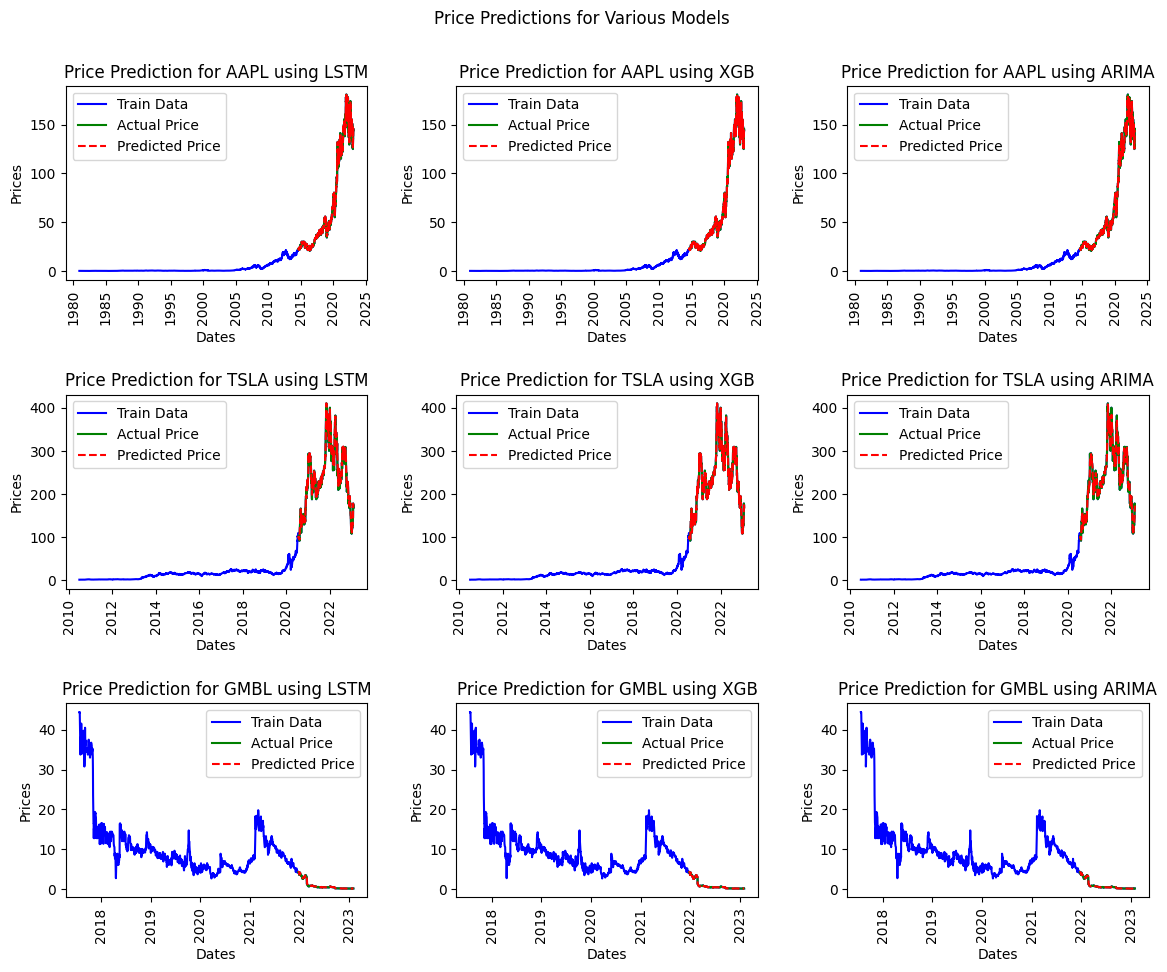

In [8]:
sub_plot()

Data Loaded
Predicting using model lstm on dataset aapl
67/67 [==============================] - 9s 91ms/step
The Mean Absolute Error for AAPL using LSTM is 0.378
The Root Mean Square Error for AAPL using LSTM is 0.88126
The Mean Absolute Percentage Error for AAPL using LSTM is 0.00493
The Accuracy for AAPL using LSTM is 99.50663


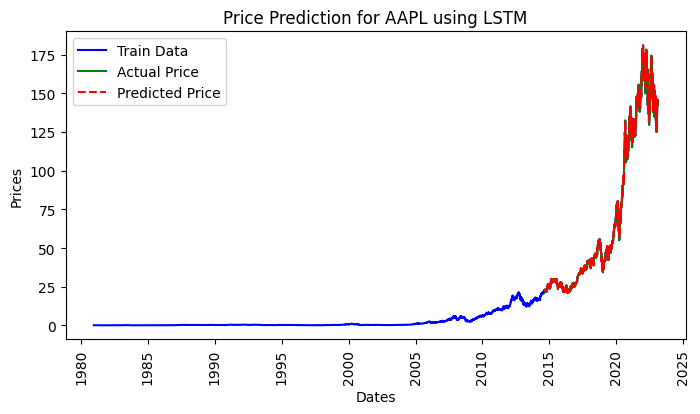

In [9]:
test_plot('lstm','aapl')

Data Loaded
Predicting using model xgb on dataset aapl
The Mean Absolute Error for AAPL using XGB is 0.01069
The Root Mean Square Error for AAPL using XGB is 0.02367
The Mean Absolute Percentage Error for AAPL using XGB is 0.00014
The Accuracy for AAPL using XGB is 99.98563


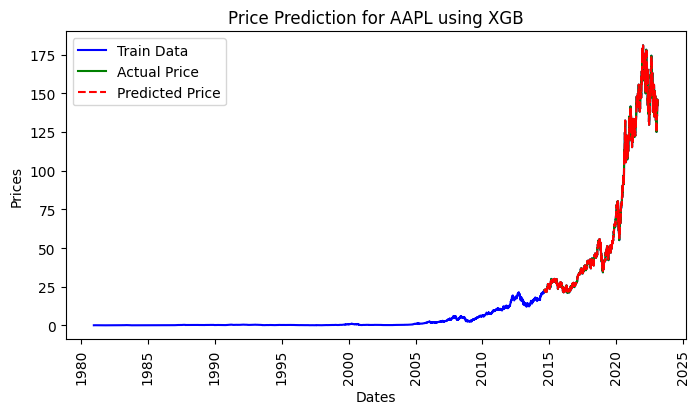

In [10]:
test_plot('xgb','aapl')

Data Loaded
Predicting using model arima on dataset aapl
The Mean Absolute Error for AAPL using ARIMA is 0.74301
The Root Mean Square Error for AAPL using ARIMA is 1.25929
The Mean Absolute Percentage Error for AAPL using ARIMA is 0.00968
The Accuracy for AAPL using ARIMA is 99.03227


C:\Users\nipun\anaconda3\envs\mlts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


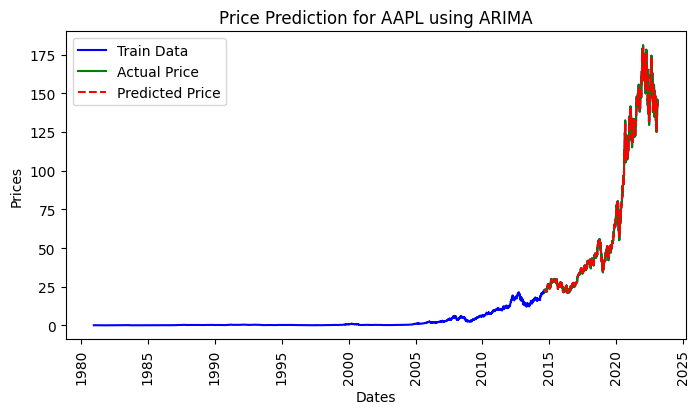

In [11]:
test_plot('arima','aapl')

Data Loaded
Predicting using model lstm on dataset tsla
20/20 [==============================] - 4s 80ms/step
The Mean Absolute Error for TSLA using LSTM is 2.8449
The Root Mean Square Error for TSLA using LSTM is 5.04719
The Mean Absolute Percentage Error for TSLA using LSTM is 0.01237
The Accuracy for TSLA using LSTM is 98.76278


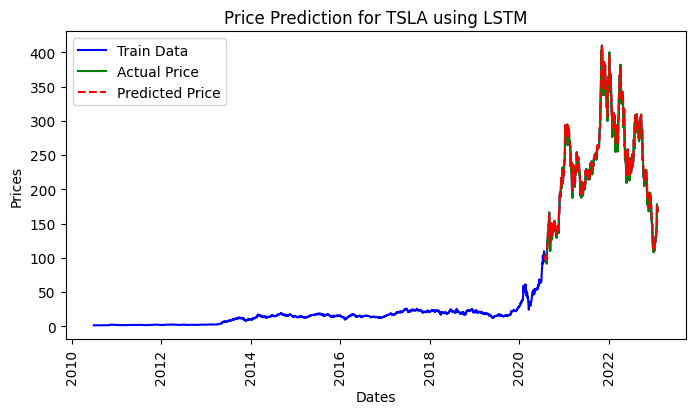

In [12]:
test_plot('lstm','tsla')

Data Loaded
Predicting using model xgb on dataset tsla
The Mean Absolute Error for TSLA using XGB is 0.10266
The Root Mean Square Error for TSLA using XGB is 0.16889
The Mean Absolute Percentage Error for TSLA using XGB is 0.00044
The Accuracy for TSLA using XGB is 99.9558


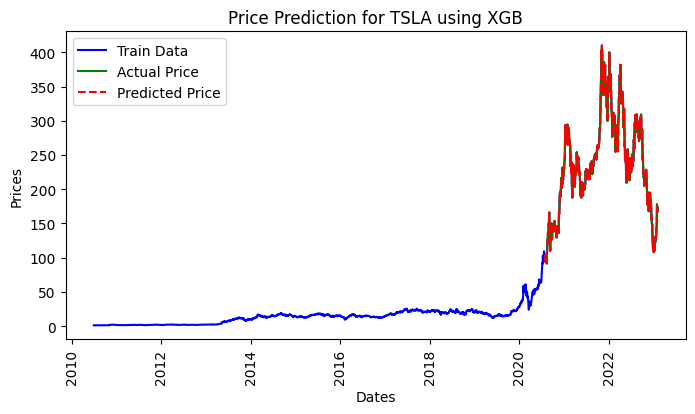

In [13]:
test_plot('xgb','tsla')

Data Loaded
Predicting using model arima on dataset tsla
The Mean Absolute Error for TSLA using ARIMA is 5.31649
The Root Mean Square Error for TSLA using ARIMA is 7.18805
The Mean Absolute Percentage Error for TSLA using ARIMA is 0.0228
The Accuracy for TSLA using ARIMA is 97.7199


C:\Users\nipun\anaconda3\envs\mlts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


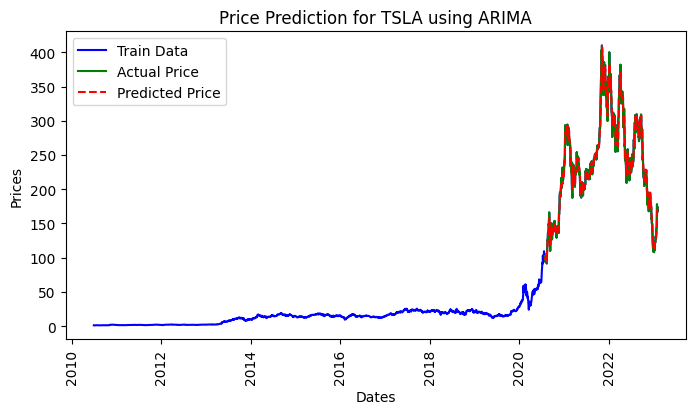

In [14]:
test_plot('arima','tsla')

Data Loaded
Predicting using model lstm on dataset gmbl
9/9 [==============================] - 3s 77ms/step
The Mean Absolute Error for GMBL using LSTM is 0.02865
The Root Mean Square Error for GMBL using LSTM is 0.09671
The Mean Absolute Percentage Error for GMBL using LSTM is 0.03906
The Accuracy for GMBL using LSTM is 96.09403


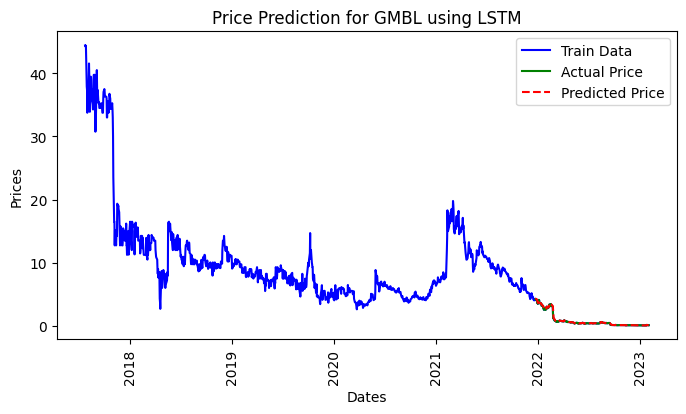

In [15]:
test_plot('lstm','gmbl')

Data Loaded
Predicting using model xgb on dataset gmbl
The Mean Absolute Error for GMBL using XGB is 0.00134
The Root Mean Square Error for GMBL using XGB is 0.00348
The Mean Absolute Percentage Error for GMBL using XGB is 0.002
The Accuracy for GMBL using XGB is 99.79989


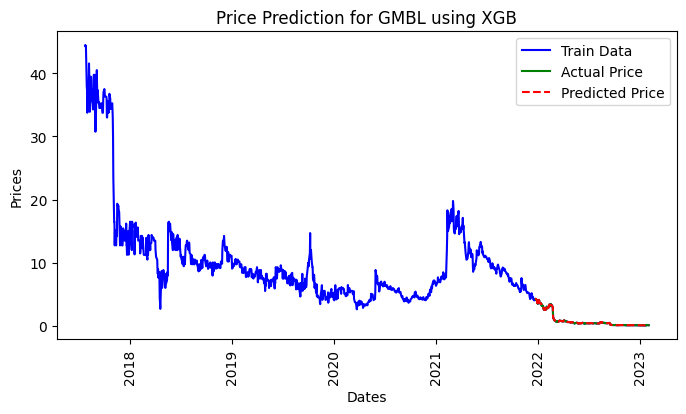

In [16]:
test_plot('xgb','gmbl')

Data Loaded
Predicting using model arima on dataset gmbl
The Mean Absolute Error for GMBL using ARIMA is 0.03883
The Root Mean Square Error for GMBL using ARIMA is 0.09805
The Mean Absolute Percentage Error for GMBL using ARIMA is 0.05284
The Accuracy for GMBL using ARIMA is 94.71577


C:\Users\nipun\anaconda3\envs\mlts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


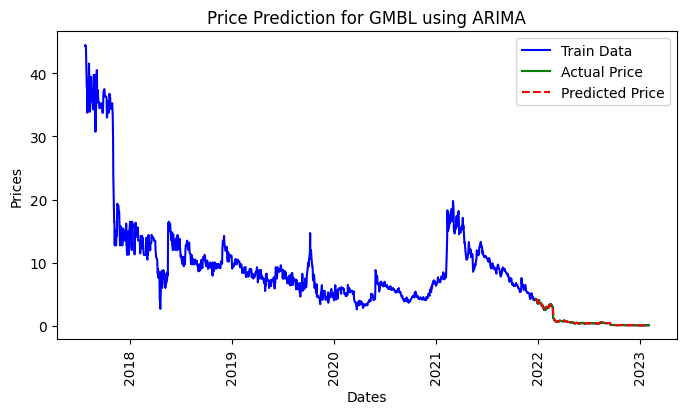

In [17]:
test_plot('arima','gmbl')